# Qubit spectroscopy: $T_1$ measurement example

This notebook demonstrates how to assess the decoherence time, $T_1$, of one or more qubits on a real quantum device using pyQuil. A $T_1$ experiment consists of an X pulse, bringing the qubit from $|0\rangle$ to $|1\rangle$ (the excited state of the artifical atom), followed by a delay of variable duration. 

The physics of the devices is such that We expect the state to decay exponentially with increasing time because of ["energy relaxation"](https://en.wikipedia.org/wiki/Relaxation_(NMR)). We characterize this decay by the time decay constant, which we call $\Gamma =1/T_1$. The parameter $T_1$ is refered to as the qubit's "relaxation" or "decoherence" time. A sample QUIL program at one data point (specified by the duration of the DELAY pragma) for qubit 0 with a 10us wait would look like 

    DECLARE ro BIT[1]
    RX(pi) 0
    PRAGMA DELAY 0 "1e-05"
    MEASURE 0 ro[0]

**NB: Since decoherence and dephasing noise are only simulated on gates, and we make use of DELAY pragmas to simulate relaxation time, we cannot simulate decoherence on the QPU with this experiment as written. This notebook should only be run on a real quantum device.**

## setup - imports and relevant units

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer

from forest.benchmarking.qubit_spectroscopy import (
    generate_t1_experiment,
    acquire_t1_data,
    estimate_t1,
    plot_t1_estimate_over_data)

We treat SI base units, such as the second, as dimensionless, unit quantities, so we define relative units, such as the microsecond, using scientific notation. 

In [ ]:
MICROSECOND = 1e-6

## measurement, analysis, and plotting

**Get a quantum computer**

In [ ]:
#qc = get_qc('Aspen-1-15Q-A')
qc = get_qc('2q-noisy-qvm') # will run on a QVM, but not meaningfully 
qubits = qc.qubits()
qubits

**Generate simultaneous $T_1$ experiments**

We make and experiment for each desired qubit in `qubits`, specifying the times in seconds at which we would like to measure the decay.

In [ ]:
import numpy as np
stop_time = 60 * MICROSECOND
num_points = 15
times = np.linspace(0, stop_time, num_points)
expts = [generate_t1_experiment(q, times) for q in qubits]
print(expts[0])

**Acquire data**

Collect our $T_1$ raw data using `acquire_t1_data`. 

In [ ]:
num_shots = 1000
acquire_t1_data(qc, expts, num_shots)

**Use the results to produce estimates of $T_1$**

This method takes a StratifiedExperiment object with all the $T_1$ data, including the times and qubit measured and the resulting decay at each data point, and fits to an exponential decay curve. 

In [ ]:
params1, errs1 = estimate_t1(expts[0])
params2, errs2 = estimate_t1(expts[1])
params = [params1, params2]
errs = [errs1, errs2]

**Now plot the fit over the data**

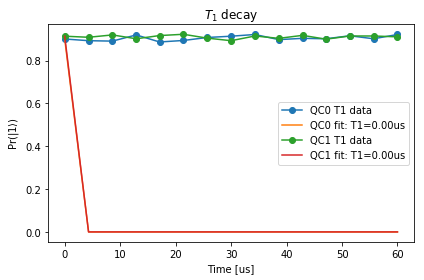

In [7]:
plot_t1_estimate_over_data(expts, params, errs)